# CLEANING OF DATA

- Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()
train_df['SalePrice'] = train_df['SalePrice'].apply(lambda x: math.log(x))

In [3]:
train_df['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

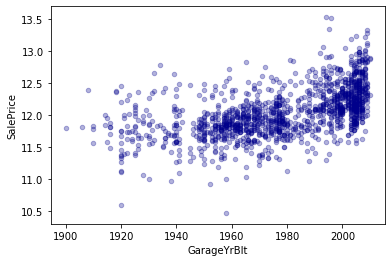

In [4]:
train_df.plot.scatter(x = 'GarageYrBlt', y = 'SalePrice', c= 'DarkBlue', alpha = 0.3)

- We filtered the data according to 4 basic criterion: Relevance, Missing data, balance of the data and repeated columns


In [5]:
insufficient_data = ['Alley', 'Fence', 'MiscFeature', 'PoolQC', 
                     'FireplaceQu', 'LotFrontage']

imbalanced_data = ['3SsnPorch','LandSlope', 'LowQualFinSF',
                   'PoolArea', 'RoofMatl', 'Street', 'Utilities']

nonsense_data = ['Condition2','BsmtHalfBath','YrSold','Id']

train_df.drop(insufficient_data + imbalanced_data + nonsense_data, axis =1, inplace = True)

- second_layer_checks to see if we missed anything with our logic

In [6]:
def correlation(dataset, threshold_upper, threshold_lower):
    corr_cols = []
    corr_matrix = dataset.corr(method = 'pearson')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold_upper or abs(corr_matrix.iloc[i,j]) <= threshold_lower):
                corr_cols.append((corr_matrix.columns[i],corr_matrix.columns[j], round(corr_matrix.iloc[i,j],5)))
    return corr_cols
#     print(dataset)

correlation(train_df,0.75, 0.05)

[('OverallQual', 'MSSubClass', 0.03263),
 ('OverallCond', 'LotArea', -0.00564),
 ('YearBuilt', 'MSSubClass', 0.02785),
 ('YearBuilt', 'LotArea', 0.01423),
 ('YearRemodAdd', 'MSSubClass', 0.04058),
 ('YearRemodAdd', 'LotArea', 0.01379),
 ('MasVnrArea', 'MSSubClass', 0.02294),
 ('BsmtFinSF1', 'OverallCond', -0.04623),
 ('BsmtFinSF2', 'OverallCond', 0.04023),
 ('BsmtFinSF2', 'YearBuilt', -0.04911),
 ('BsmtUnfSF', 'LotArea', -0.00262),
 ('1stFlrSF', 'TotalBsmtSF', 0.81953),
 ('2ndFlrSF', 'OverallCond', 0.02894),
 ('2ndFlrSF', 'YearBuilt', 0.01031),
 ('2ndFlrSF', 'BsmtUnfSF', 0.00447),
 ('GrLivArea', 'BsmtFinSF2', -0.00964),
 ('BsmtFullBath', 'MSSubClass', 0.00349),
 ('BsmtFullBath', 'GrLivArea', 0.03484),
 ('HalfBath', 'LotArea', 0.01426),
 ('HalfBath', 'BsmtFinSF1', 0.00426),
 ('HalfBath', 'BsmtFinSF2', -0.03215),
 ('HalfBath', 'BsmtUnfSF', -0.04112),
 ('HalfBath', 'TotalBsmtSF', -0.0488),
 ('HalfBath', 'BsmtFullBath', -0.0309),
 ('BedroomAbvGr', 'MSSubClass', -0.02344),
 ('BedroomAbvGr',

- Might not need to drop because correlations between variables do not really affect the predictive capabilities of the model
- Consider looking at variables with very low correlation to the SalesPrice: Potentially can drop

In [7]:
second_check = ['TotRmsAbvGrd', 'TotalBsmtSF']
train_df.drop(second_check, axis =1, inplace = True)
# train_df.shape

# MISSING DATA

In [8]:
missing_data = train_df.isna().sum() / train_df.shape[0]
missing_data[missing_data > 0]

MasVnrType      0.005479
MasVnrArea      0.005479
BsmtQual        0.025342
BsmtCond        0.025342
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtFinType2    0.026027
Electrical      0.000685
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
dtype: float64

In [9]:
train_df[(train_df['BsmtFinType1'].isna() == False) & (train_df['BsmtFinType2'].isna() == True)][['BsmtFinType1', 'BsmtFinType2']]

,BsmtFinType1,BsmtFinType2
332,GLQ,NaN


In [10]:
print(train_df['Electrical'].value_counts())
print()
print(train_df['MasVnrType'].value_counts())

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64


- We should not remove the missing data with no basement. Likely to not be missing at random. We introduce new category called 'No Basement'
- For electrical, because we only have 1 missing row, we think it is reasonable to use the mode of the variable to fill this missing value
- For MasVnrType and MasVnrArea, we filled NA to assume that there is no MasVnr. Easiest way of dealing with inputting categorical for now

In [11]:
train_df.update(train_df[['BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna('No Basement'))
train_df['Electrical'] = train_df['Electrical'].fillna('SBrkr')
train_df['MasVnrType'] = train_df['MasVnrType'].fillna('None')
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(0)

- Methods to input categorical: 1. Use the mode (introduce bias), 2. Missing values as new category, 3. Use classification algorithm to predict like Logistic regression / KNN

# PREPROCESSING

In [12]:
train_df.corr(method='pearson').style.background_gradient(cmap='coolwarm')

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,MoSold,SalePrice
MSSubClass,1,-0.139781,0.0326277,-0.0593158,0.0278501,0.040581,0.023573,-0.0698357,-0.0656486,-0.140759,-0.251758,0.307886,0.0748532,0.00349103,0.131608,0.177354,-0.023438,0.281721,-0.0455693,0.0850719,-0.0401098,-0.0986715,-0.0125794,-0.00610012,-0.0120366,-0.0260302,-0.00768329,-0.0135846,-0.073959
LotArea,-0.139781,1,0.105806,-0.00563627,0.0142277,0.0137884,0.103321,0.214103,0.11117,-0.00261836,0.299475,0.0509859,0.263116,0.158155,0.126031,0.0142595,0.11969,-0.0177839,0.271364,-0.0249474,0.154871,0.180403,0.171698,0.0847738,-0.0183397,0.0431604,0.0380677,0.00120499,0.25732
OverallQual,0.0326277,0.105806,1,-0.0919323,0.572323,0.550684,0.407252,0.239666,-0.0591187,0.308159,0.476224,0.295493,0.593007,0.111098,0.5506,0.273458,0.101676,-0.183882,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.0648864,-0.0314062,0.0708152,0.817184
OverallCond,-0.0593158,-0.00563627,-0.0919323,1,-0.375983,0.0737415,-0.125694,-0.0462309,0.0402292,-0.136841,-0.144203,0.0289421,-0.0796859,-0.0549415,-0.194149,-0.0607693,0.0129801,-0.0870009,-0.02382,-0.324297,-0.185758,-0.151521,-0.0033337,-0.0325888,0.0703562,0.0548105,0.0687768,-0.00351084,-0.036868
YearBuilt,0.0278501,0.0142277,0.572323,-0.375983,1,0.592855,0.3116,0.249503,-0.0491068,0.14904,0.281986,0.0103077,0.19901,0.187599,0.468271,0.242656,-0.0706512,-0.1748,0.147716,0.825667,0.53785,0.478954,0.22488,0.188686,-0.387268,-0.0503644,-0.0343831,0.0123985,0.58657
YearRemodAdd,0.040581,0.0137884,0.550684,0.0737415,0.592855,1,0.176529,0.128451,-0.0677585,0.181133,0.240379,0.140024,0.287389,0.11947,0.439046,0.183331,-0.0405809,-0.149598,0.112581,0.642277,0.420622,0.3716,0.205726,0.226298,-0.193919,-0.03874,-0.0102862,0.02149,0.565608
MasVnrArea,0.023573,0.103321,0.407252,-0.125694,0.3116,0.176529,1,0.261256,-0.0713296,0.113862,0.33985,0.1738,0.388052,0.08301,0.272999,0.199108,0.102775,-0.0384501,0.247015,0.248546,0.361945,0.370884,0.159991,0.122528,-0.109907,0.0622477,-0.0295122,-0.0067232,0.426775
BsmtFinSF1,-0.0698357,0.214103,0.239666,-0.0462309,0.249503,0.128451,0.261256,1,-0.0501174,-0.495251,0.445863,-0.137079,0.208171,0.649212,0.0585431,0.00426242,-0.107355,-0.0810069,0.260011,0.153484,0.224054,0.29697,0.204306,0.111761,-0.102303,0.0620206,0.00357147,-0.0157269,0.372023
BsmtFinSF2,-0.0656486,0.11117,-0.0591187,0.0402292,-0.0491068,-0.0677585,-0.0713296,-0.0501174,1,-0.209294,0.0971174,-0.0992603,-0.00963989,0.158678,-0.0764439,-0.0321478,-0.0157281,-0.0407512,0.0469207,-0.0880108,-0.0382635,-0.0182266,0.0678983,0.00309256,0.0365433,0.0888713,0.00493978,-0.0152107,0.00483241
BsmtUnfSF,-0.140759,-0.00261836,0.308159,-0.136841,0.14904,0.181133,0.113862,-0.495251,-0.209294,1,0.317987,0.00446909,0.240257,-0.4229,0.288886,-0.0411175,0.166643,0.0300859,0.0515749,0.190708,0.214175,0.183303,-0.00531642,0.129005,-0.00253785,-0.0125793,-0.0238366,0.0348884,0.221985


- MSSubClass is a qualitative variable cannot be seen as quantitative
- Dropping SalePrice from our cleaning because it is the dependent variable

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import metrics

In [14]:
train_df['MSSubClass'].value_counts()
train_df = train_df.astype({'MSSubClass': 'object'})
y = train_df['SalePrice']
train_df.drop('SalePrice', axis = 1, inplace= True)

- Qualitative variables have to encoded using one hot encoding, so that you can run regression
- Quantitative variables have to be standardised so that you can use Regularisation effectively

In [15]:
qual_variables = list(train_df.columns[train_df.dtypes == 'object'])
qual_variables =pd.get_dummies(train_df[qual_variables], prefix = qual_variables, columns =  qual_variables)
qual_variables.head()

,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [16]:
quant_variables = list(train_df.columns[train_df.dtypes != 'object'])
standardized_values = preprocessing.StandardScaler().fit_transform(train_df[quant_variables])
standardized_values = pd.DataFrame(standardized_values, columns = quant_variables)

- X_model_1 contains variables used for the original linear regresson model (without standardized values)
- X_model_2 contains standardised values

In [17]:
X_model_1= pd.merge(train_df[quant_variables], qual_variables, left_index = True, right_index = True)
X_model_2 = pd.merge(standardized_values, qual_variables, left_index = True, right_index = True)

- Comparing the results of standardisation. Seeing if it is similar to manual application of formula

In [18]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_model_2, y, test_size = 0.20, random_state = 10)

In [19]:
print((8450 - (sum(X_model_1['LotArea'])/len(X_model_1))) / (X_model_1['LotArea'].std()))
print(X_model_2['LotArea'][0])

-0.2070707566820521
-0.20714170777431132


# LINEAR REGRESSION

- Small difference due to standardisation

In [20]:
# lr = LinearRegression()
# lr.fit(X_train_1,y)
# train_score = lr.score(X_train_1,y)
# print(train_score)

lr2 = LinearRegression().fit(X_train_2,y_train_2)
train_score = lr2.score(X_train_2,y_train_2)
y_pred = lr2.predict(X_test_2)
y_pred_train = lr2.predict(X_train_2)
MSE1 = metrics.mean_squared_error(y_test_2, y_pred)
MAE1 = metrics.mean_absolute_error(y_test_2, y_pred)
MSE_train_1 = metrics.mean_squared_error(y_train_2, y_pred_train)
print('The TRAIN MSE for our Multivariate Linear Regression Model is', MSE_train_1)
print('The TEST MSE for our Multivariate Linear Regression Model is ', MSE1)
print('The TEST MAE for our Multivariate Linear Regression Model is ', MAE1)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# RIDGE REGRESSION

In [ ]:
rr = Ridge(alpha = 0.90)
rr.fit(X_train_2,y_train_2)
y_pred_2 = rr.predict(X_test_2)
y_pred_train_2 = rr.predict(X_train_2)
MSE2 = metrics.mean_squared_error(y_test_2, y_pred_2)
MAE2 = metrics.mean_absolute_error(y_test_2, y_pred_2)
MSE_train_2 = metrics.mean_squared_error(y_train_2, y_pred_train_2)
print('The TRAIN MSE for our Ridge Regression Model is ', MSE_train_2)
print('The TEST MSE for our Ridge Regression Model is ', math.sqrt(MSE2))
print('The TEST MAE for our Ridge Regression Model is ', MAE2)

- Tuning of parameters using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {'alpha': [0.1, 0.5, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]}
ridge_regressor = GridSearchCV(rr, parameters, scoring = 'neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_train_2,y_train_2)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

In [ ]:
rr = Ridge(alpha=25)
rr.fit(X_train_2,y_train_2)
y_pred_2 = rr.predict(X_test_2)
y_pred_train_2 = rr.predict(X_train_2)
MSE2 = metrics.mean_squared_error(y_test_2, y_pred_2)
MAE2 = metrics.mean_absolute_error(y_test_2, y_pred_2)
MSE_train_2 = metrics.mean_squared_error(y_train_2, y_pred_train_2)
RMSE2 = sqrt(MSE2)
print('The TRAIN MSE for our Ridge Regression Model is ', MSE_train_2)
print('The TEST MSE for our Ridge Regression Model is ', MSE2)
print('The TEST MAE for our Ridge Regression Model is ', MAE2)
print('The TEST RMSE for our Ridge Regression Model is', RMSE2)

# LASSO REGRESSION

In [ ]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.3)
lasso.fit(X_train_2, y_train_2)
y_pred_lasso = lasso.predict(X_test_2)
y_pred_lasso_train_2 = lasso.predict(X_train_2)
MSE2 = metrics.mean_squared_error(y_test_2, y_pred_lasso)
MAE2 = metrics.mean_absolute_error(y_test_2, y_pred_lasso)
MSE_train_2 = metrics.mean_squared_error(y_train_2, y_pred_lasso_train_2)
RMSE2 = sqrt(MSE2)
print('The TRAIN MSE for our Ridge Regression Model is ', MSE_train_2)
print('The TEST MSE for our Ridge Regression Model is ', MSE2)
print('The TEST MAE for our Ridge Regression Model is ', MAE2)
print('The TEST RMSE for our Ridge Regression Model is', RMSE2)

In [ ]:
parameters = {'alpha': [1e-10, 1e-5, 0.1, 0.5, 1, 5, 10, 15, 20, 25, 30]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train_2, y_train_2)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

In [ ]:
lasso_tuned = Lasso(alpha=30)
lasso_tuned.fit(X_train_2, y_train_2)
y_pred_lasso = lasso_tuned.predict(X_test_2)
y_pred_lasso_train_2 = lasso_tuned.predict(X_train_2)
MSE2 = metrics.mean_squared_error(y_test_2, y_pred_lasso)
MAE2 = metrics.mean_absolute_error(y_test_2, y_pred_lasso)
MSE_train_2 = metrics.mean_squared_error(y_train_2, y_pred_lasso_train_2)
RMSE2 = sqrt(MSE2)
print('The TRAIN MSE for our Ridge Regression Model is ', MSE_train_2)
print('The TEST MSE for our Ridge Regression Model is ', MSE2)
print('The TEST MAE for our Ridge Regression Model is ', MAE2)
print('The TEST RMSE for our Ridge Regression Model is', RMSE2)

In [ ]:
lasso_tuned_coef = lasso_tuned.coef_
print(lasso_tuned_coef)

In [ ]:
colnames = X_train_2.columns

plt.figure(figsize=(60,10)) #Set the size of the graph
plt.bar(range(len(colnames)), lasso_tuned_coef)
plt.xticks(range(len(colnames)), colnames.values, rotation=90) 
plt.margins(0.02)
plt.show()

In [ ]:
coef_tuned_lasso = pd.Series(lasso_tuned.coef_, index= X_train_2.columns)
coef_tuned_lasso

In [ ]:
plt.rcParams['figure.figsize'] = (8.0, 50)
coef_tuned_lasso.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
regressor = RandomForestRegressor(n_estimators = 150, random_state = 10)
regressor.fit(X_train_2, y_train_2)
y_pred_RF = regressor.predict(X_test_2)
y_pred_train_RF = regressor.predict(X_train_2)

In [ ]:
MSE_RF = metrics.mean_squared_error(y_test_2, y_pred_RF)
MSE_train_RF = metrics.mean_squared_error(y_train_2, y_pred_train_RF)
print('The TRAIN RMSE for our Model is ', round(math.sqrt(MSE_train_RF),2))
print('The TEST RMSE for our RF Model is ', round(math.sqrt(MSE_RF),2))

- Can consider iterating through various values of alpha, to get the lowest
- Can use Lasso regression to look at the weights given to the feature. Low weights indicative that the feature is not important

In [ ]:
from sklearn.ensemble import BaggingRegressor